#### This notebook intends to explore the CMIP6 sea level data and also compare this to the tide gauge data along the Dutch coast

In [13]:
# Load necessary packages
import xarray as xr
import glob
import sys
import numpy as np

#sys.path.insert(1, '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/Data preparation/code')
from Import_data import import_obs_slh_data

#from /Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/Wind_contribution/Analysis/code/Import_data.py import import_obs_slh_data

In [14]:
# Import necessary packages
import xarray as xr # used for analysing netcdf format data
from xarray import DataArray
import netCDF4
import numpy as np
import matplotlib
from scipy.signal import detrend
from scipy.stats import linregress
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import regionmask
from sklearn.linear_model import LinearRegression as linr
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import copy
from statistics import mean

#### Observational data

In [68]:
def import_obs_slh_data():
    
    # Define paths to data
    path_tg = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/rlr_annual'
    path_locations = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/rlr_annual/filelist.txt'
    
    # Import tide gauge sea level data
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
    filelist_df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    filelist_df = filelist_df.set_index('id')
    filelist_df = filelist_df.loc[loc_num, :]
    names_col = ('time', 'height', 'interpolated', 'flags')
    station_names = []

    for i in range(len(loc_num)):
            tg_data = pd.read_csv(path_tg + '/data/' + str(loc_num[i]) + 
                                  '.rlrdata', sep=';', header=None, names=names_col)
            tg_data = tg_data.set_index('time')
            tg_data.height = tg_data.height.where(~np.isclose(tg_data.height,-99999))
            tg_data.height = tg_data.height - tg_data.height.mean()

            if i==0:
                tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, col_name=tg_data.height))
                tg_data_df = tg_data_df.set_index('time')
                tg_data_df.columns  = [str(loc_num[i])] 
            else:
                tg_data_df[str(loc_num[i])] = tg_data.height
            station_names.append(filelist_df['name'].loc[loc_num[i]].strip())
            
    tg_data_df = tg_data_df.rename(columns={"20": station_names[0], 
                              "22": station_names[1], "23": station_names[2],
                              "24": station_names[3], "25": station_names[4],
                              "32": station_names[5]})

    tg_data_df = tg_data_df.interpolate(method='slinear')
    tg_data_df['Average'] = tg_data_df.mean(axis=1) # Add column containing the average of the stations 
    tg_data_df = tg_data_df*0.001 # cm -> m
    
    # Data before 1890 is incorrect
    tg_data_df = tg_data_df[tg_data_df.index>=1890] 
    
    
    return tg_data_df

In [69]:
tg_data = import_obs_slh_data()

In [70]:
station_names = list(tg_data.columns)[:-1]
station_names_av = station_names + ['Average']

In [87]:
# Detrend data
detrend_lst = []
for station in station_names:
    detrend_lst.append(detrend(tg_data[station]))
tg_dt_data = pd.DataFrame(detrend_lst)
tg_dt_data = tg_dt_data.transpose()
tg_dt_data.columns = station_names
tg_dt_data['time'] = tg_data.index
tg_dt_data = tg_dt_data.set_index('time')

<AxesSubplot:title={'center':'Tide gauge time series'}, xlabel='time', ylabel='Sea level height above NAP [m]'>

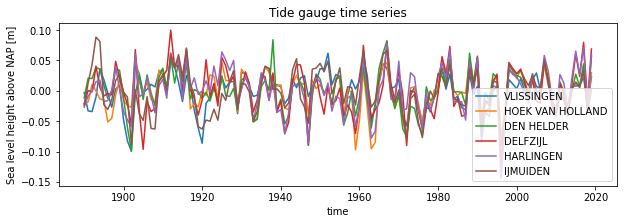

In [89]:
tg_dt_data.plot(figsize=(10,3), title='Tide gauge time series', ylabel = 'Sea level height above NAP [m]')

#### CMIP6 data

##### Historical

In [101]:
# Define path to cmip6 data
data_dir = '/Volumes/Iris 300 GB/CMIP6'

In [102]:
# Function to import all models of a cmip6 data series as one dataset
def import_cmip6(sce, var):
    
    if sce == 'piControl':
        return xr.open_dataset(f'{data_dir}/cmip6_{var}_piControl/Datasets/cmip6_{var}_piControl_northsea_all_models.nc')
    
    else: 
        return xr.open_mfdataset(f'{data_dir}/cmip6_{var}_{sce}/cmip6_{var}_{sce}_*.nc')

In [103]:
slh_hist_ds = import_cmip6('historical', 'zos')

In [104]:
slh_hist_ds = slh_hist_ds.rename({"CorrectedReggrided_zos":"cmip6_slh"})

In [107]:
slh_hist_ds = slh_hist_ds.dropna('lat', how='all')

/Users/iriskeizer/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [108]:
slh_hist_ds = slh_hist_ds.dropna('lon', how='all')

In [109]:
# Select sea level data close to tide gauge station
loc_num = [20, 22, 23, 24, 25, 32]
col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
path_locations = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/rlr_annual/filelist.txt'
filelist_df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
filelist_df = filelist_df.set_index('id')
filelist_df = filelist_df.loc[loc_num, :]

tg_lst_ds = []
tg_lst_df = []
for idx, i in enumerate(loc_num):
    tg_lst_ds.append(slh_hist_ds.cmip6_slh.sel(lon = filelist_df['lon'].loc[i], lat = filelist_df['lat'].loc[i], method = 'nearest', drop=True))
    model_lst = []
    for model in slh_hist_ds.model:
        model_lst.append(slh_hist_ds.cmip6_slh.sel(model=model, drop=True).sel(lon = filelist_df['lon'].loc[i], lat = filelist_df['lat'].loc[i], method = 'nearest', drop=True).to_series())
    tg_lst_df.append(pd.concat(model_lst, axis=1, keys = slh_hist_ds.model.values))
slh_hist_northsea_ds = xr.concat(tg_lst_ds, dim = station_names).rename({"concat_dim":"tg_station"})
slh_hist_northsea_df = pd.concat(tg_lst_df, axis=1, keys = station_names)

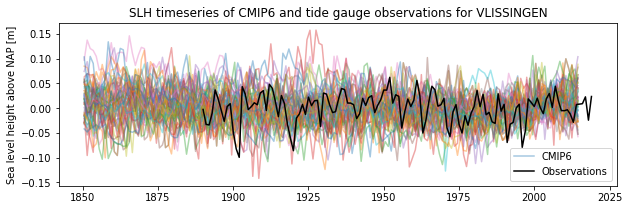

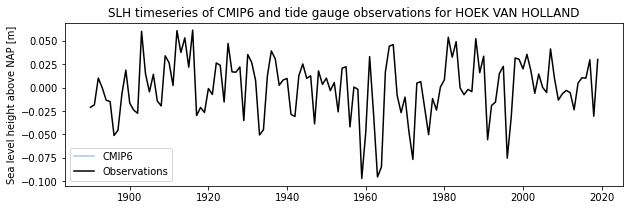

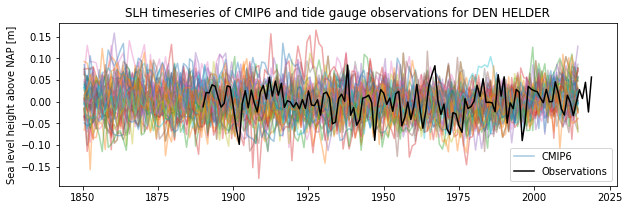

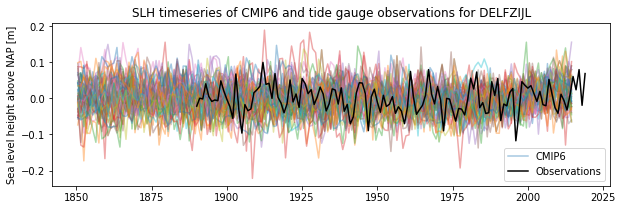

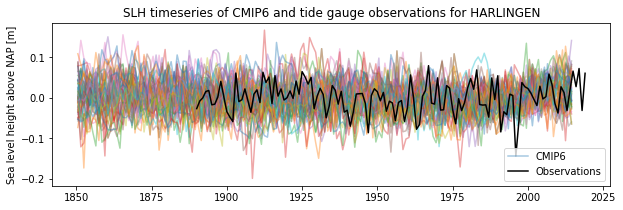

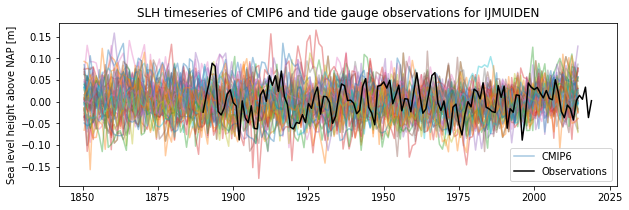

In [112]:
for station in station_names:
    plt.figure(figsize = (10,3))
    plt.title(f'SLH timeseries of CMIP6 and tide gauge observations for {station}')
    plt.ylabel('Sea level height above NAP [m]')
    for i, model in enumerate(slh_northsea_df[station].columns):
        if i == 0:
            plt.plot(slh_hist_northsea_df.index, slh_hist_northsea_df[station][model]*0.01, alpha=0.4, label = 'CMIP6')
        plt.plot(slh_hist_northsea_df.index, slh_hist_northsea_df[station][model]*0.01, alpha=0.4)
    plt.plot(tg_dt_data.index, tg_dt_data[station], label = 'Observations',  color='k')
    plt.legend()
    plt.savefig(f'/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Figures/Wind contribution/Comparison/slh_hist_{station}.png')

In [132]:
# Function that plots the locations of the tide gauge stations and the nearest wind stres data point
def nearest_points_plot(data):
    
    # plot location of tide gauge station and wind coordinates used for regression
    #fig, ax = plt.subplots(figsize = (10,10))
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title('Locations of tide gauge data and nearest cmip6 data')
    #ax.set_extent([3.3, 7.2, 50.7, 54], ccrs.PlateCarree())
    #ax.coastlines(resolution='10m')

    for idx, i in enumerate(loc_num):
        plt.scatter(filelist_df['lon'].loc[i], filelist_df['lat'].loc[i], 
                    s=40, marker='x', label = filelist_df['name'].loc[i]) # plot tg station location
        lon = data.sel(lon = filelist_df['lon'].loc[i], lat = filelist_df['lat'].loc[i], method = 'nearest').lon.values.tolist()
        lat = data.sel(lon = filelist_df['lon'].loc[i], lat = filelist_df['lat'].loc[i], method = 'nearest').lat.values.tolist()
        if idx == 5:
            plt.scatter(lon, lat,
                        s=40, marker='x', color='grey', label = 'CMIP6') # plot wind data location
        else:
            plt.scatter(lon, lat, s=40, marker='x', color='grey') # plot wind data location
    plt.title('Locations of tide gauge data and nearest cmip6 data')
    plt.legend(loc = 'lower right')
    plt.savefig(f'/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Figures/Wind contribution/Comparison/cmip6_locations.png')
    plt.show()   



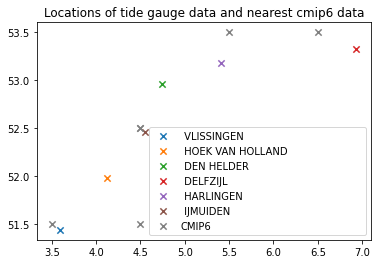

In [133]:
nearest_points_plot(slh_hist_ds.sel(model=slh_hist_ds.model[0]))

##### piControl

In [96]:
slh_picont_ds = import_cmip6('piControl', 'zos')

In [97]:
slh_picont_ds = slh_picont_ds.rename({"CorrectedReggrided_zos":"cmip6_slh"})

In [98]:
# Select sea level data close to tide gauge station
loc_num = [20, 22, 23, 24, 25, 32]
col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
path_locations = '/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Data/observations/SLH/rlr_annual/filelist.txt'
filelist_df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
filelist_df = filelist_df.set_index('id')
filelist_df = filelist_df.loc[loc_num, :]

tg_lst_ds = []
tg_lst_df = []
for idx, i in enumerate(loc_num):
    tg_lst_ds.append(slh_picont_ds.cmip6_slh.sel(lon = filelist_df['lon'].loc[i], lat = filelist_df['lat'].loc[i], method = 'nearest', drop=True))
    model_lst = []
    for model in slh_picont_ds.model:
        model_lst.append(slh_picont_ds.cmip6_slh.sel(model=model, drop=True).sel(lon = filelist_df['lon'].loc[i], lat = filelist_df['lat'].loc[i], method = 'nearest', drop=True).to_series())
    tg_lst_df.append(pd.concat(model_lst, axis=1, keys = slh_picont_ds.model.values))
slh_picont_northsea_ds = xr.concat(tg_lst_ds, dim = station_names).rename({"concat_dim":"tg_station"})
slh_picont_northsea_df = pd.concat(tg_lst_df, axis=1, keys = station_names)

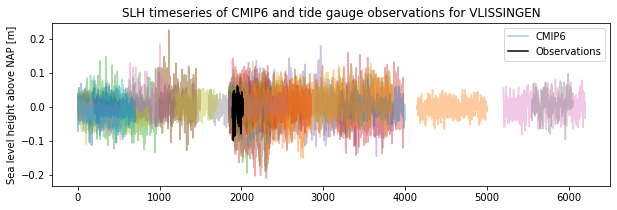

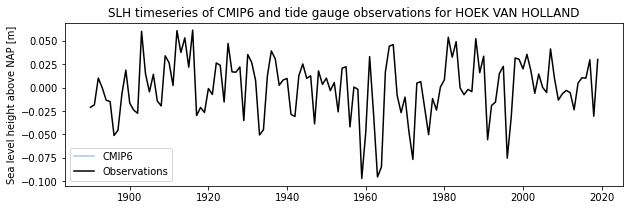

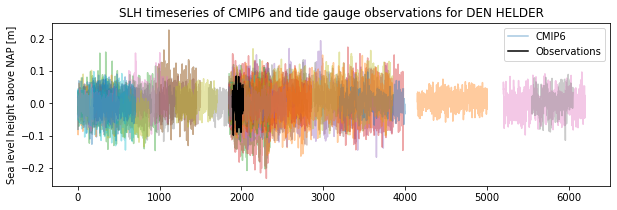

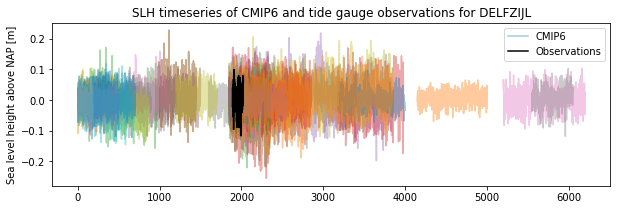

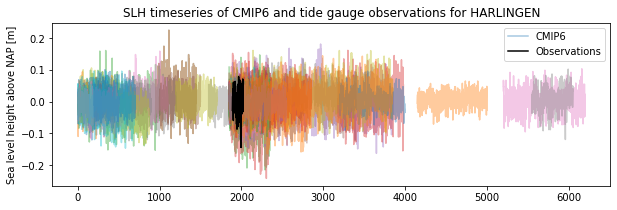

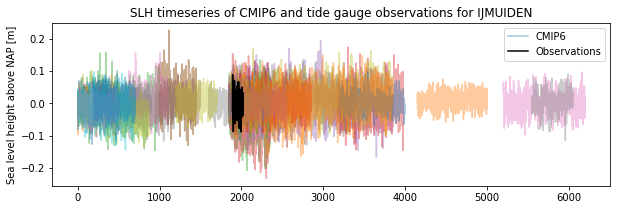

In [113]:
for station in station_names:
    plt.figure(figsize = (10,3))
    plt.title(f'SLH timeseries of CMIP6 and tide gauge observations for {station}')
    plt.ylabel('Sea level height above NAP [m]')
    for i, model in enumerate(slh_northsea_df[station].columns):
        if i == 0:
            plt.plot(slh_picont_northsea_df.index, slh_picont_northsea_df[station][model]*0.01, alpha=0.4, label = 'CMIP6')
        plt.plot(slh_picont_northsea_df.index, slh_picont_northsea_df[station][model]*0.01, alpha=0.4)
    plt.plot(tg_dt_data.index, tg_dt_data[station], label = 'Observations',  color='k')
    plt.legend()
    plt.savefig(f'/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Figures/Wind contribution/Comparison/slh_picont_{station}')